In [167]:
%reload_ext autoreload
%autoreload 2

from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
)
from ripple_heterogeneity.replay import replay_run, influence_of_layer_bias_on_replay
from ripple_heterogeneity.readout import readout_explained_var
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nelpy as nel
import nelpy.plotting as npl
from matplotlib.ticker import AutoMinorLocator
from sklearn.cluster import KMeans
import os
from scipy import stats
from ripple_heterogeneity.readout import ripple_bias_downstream_v2
from statannotations.Annotator import Annotator

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

In [2]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")

region_df = pd.DataFrame()
for basepath in df.basepath:
    brainRegions = loading.load_brain_regions(basepath)
    temp_df = pd.DataFrame()
    temp_df["brainRegions"] = brainRegions.keys()
    temp_df["basepath"] = basepath
    region_df = pd.concat([region_df, temp_df], ignore_index=True)

sessions = region_df[region_df.brainRegions.str.contains("PFC|EC1|EC2|EC3|EC4|EC5|MEC")]
df_sessions = pd.DataFrame()
df_sessions["basepath"] = sessions.basepath.unique()
df_sessions


,basepath
0,Z:\Data\AYAold\AYA7\day19
1,Z:\Data\AYAold\AYA7\day20
2,Z:\Data\AYAold\AYA7\day24
3,Z:\Data\AYAold\AYA7\day25
4,Z:\Data\AYAold\AYA7\day27
...,...
112,Z:\Data\Kenji\i01_maze15_MS.001_004
113,Z:\Data\Kenji\nlx_070329
114,Z:\Data\ORproject\OR18\day1
115,Z:\Data\ORproject\OR18\day2


## Main anaylsis

In [148]:
# basepath = r"Z:\Data\HMC1\day13"
# results = ripple_bias_downstream_v2.run(basepath)

save_path = (
    r"Z:\home\ryanh\projects\ripple_heterogeneity\ripple_layer_bias_all_ripples_v4"
)

batch_analysis.run(
    df_sessions,
    save_path,
    ripple_bias_downstream_v2.run,
    parallel=True,
    overwrite=False,
    verbose=True,
)
# load results
df_layer_bias = ripple_bias_downstream_v2.load_results(save_path)


100%|██████████| 117/117 [01:30<00:00,  1.29it/s]


In [149]:
df_layer_bias = df_layer_bias.query("n_deep > 5 & n_sup > 5").reset_index(drop=True)


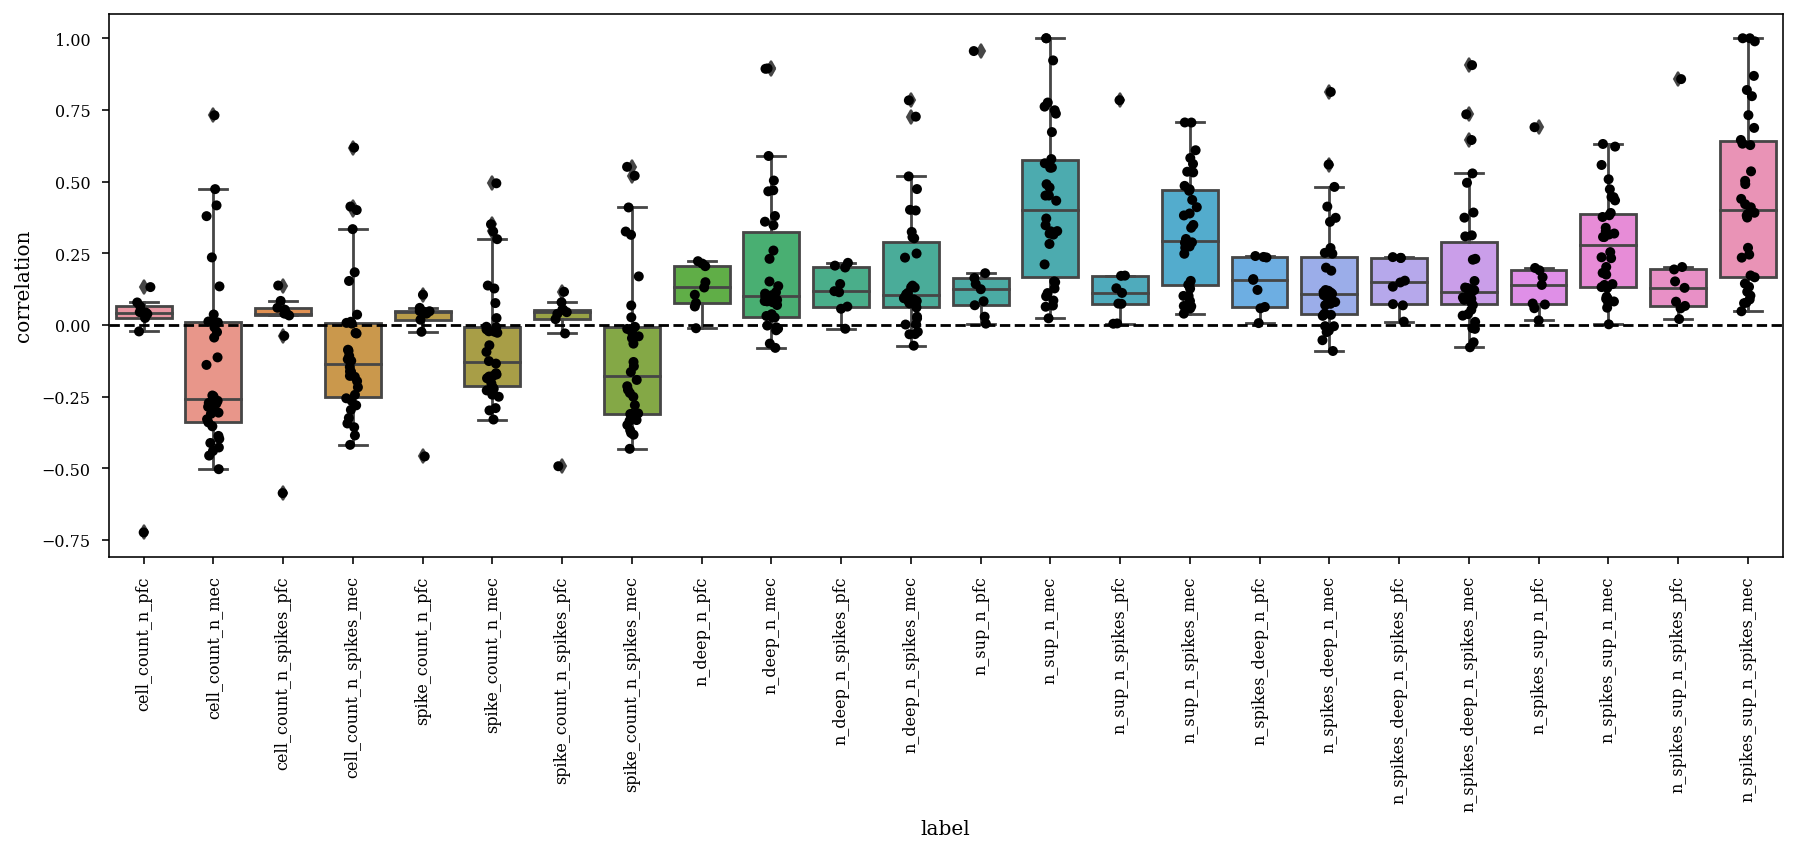

In [154]:
plt.figure(figsize=(15, 5))
sns.boxplot(x="label", y="correlation", data=df_layer_bias)
sns.stripplot(
    x="label", y="correlation", data=df_layer_bias, color="k", jitter=True, size=5
)
plt.axhline(0, color="k", linestyle="--")
plt.xticks(rotation=90)
plt.show()


In [182]:
df_layer_bias.query("correlation > 0 & label=='cell_count_n_mec'")

,correlation,label,n_deep,n_sup,n_middle,n_pfc,n_mec,basepath,constant
1,0.473598,cell_count_n_mec,62,11,22,0,50,Z:\Data\AYAold\AYA7\day24,1
241,0.011702,cell_count_n_mec,45,24,26,137,31,Z:\Data\HMC1\day10,1
265,0.036227,cell_count_n_mec,29,37,27,87,62,Z:\Data\HMC1\day12,1
313,0.008417,cell_count_n_mec,30,16,28,141,23,Z:\Data\HMC1\day8,1
337,0.008493,cell_count_n_mec,36,12,21,154,24,Z:\Data\HMC1\day9,1
577,0.731145,cell_count_n_mec,11,6,0,0,15,Z:\Data\Kenji\ec014.120_130,1
601,0.416872,cell_count_n_mec,27,6,40,0,10,Z:\Data\Kenji\ec014.192_204,1
625,0.134228,cell_count_n_mec,34,6,32,0,6,Z:\Data\Kenji\ec014.207_234,1
673,0.379319,cell_count_n_mec,27,8,39,0,7,Z:\Data\Kenji\ec014.271_287,1
697,0.235353,cell_count_n_mec,14,12,15,0,6,Z:\Data\Kenji\ec014.329_340,1


In [ ]:
group_colors = {
    "cell_count_n_mec": "#de2020",
    "cell_count_n_pfc": "#116f70",
}

(<AxesSubplot:xlabel='constant', ylabel='deep/sup vs. active cortical cells (r)'>,
 [<statannotations.Annotation.Annotation at 0x29badf12ee0>])

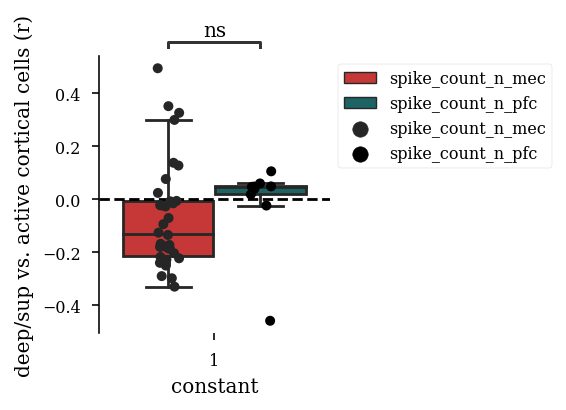

In [180]:
group_colors = {
    "spike_count_n_mec": "#de2020",
    "spike_count_n_pfc": "#116f70",
}
sns.set_palette(sns.color_palette(group_colors.values()))

df_layer_bias["constant"] = 1

fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.35, subplots=(2, 1)), edgecolor=None
)
sns.boxplot(
    x="constant",
    y="correlation",
    data=df_layer_bias.query(
        "label == 'spike_count_n_mec' | label == 'spike_count_n_pfc'"
    ),
    hue="label",
    hue_order=group_colors.keys(),
    showfliers=False,
)

sns.stripplot(
    x="constant",
    y="correlation",
    data=df_layer_bias.query(
        "label == 'spike_count_n_mec' | label == 'spike_count_n_pfc'"
    ),
    hue="label",
    hue_order=group_colors.keys(),
    color="k",
    dodge=True,
    jitter=True,
    size=5,
)
plt.axhline(0, color="k", linestyle="--")
sns.despine(bottom=True)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.ylabel("deep/sup vs. active cortical cells (r)")

box_pairs = [
    ((1, "spike_count_n_mec"), (1, "spike_count_n_pfc")),
]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=df_layer_bias.query(
        "label == 'spike_count_n_mec' | label == 'spike_count_n_pfc'"
    ),
    x="constant",
    y="correlation",
    hue="label",
    hue_order=group_colors.keys(),
)
annotator.configure(
    test="Mann-Whitney",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=0,
)
annotator.apply_and_annotate()


In [3]:
# for basepath in df_sessions.basepath.unique():
basepath = r"Z:\Data\HMC1\day13"
st, cm = loading.load_spikes(
    basepath, putativeCellType="Pyr", brainRegion="CA1|PFC|EC1|EC2|EC3|EC4|EC5|MEC"
)
cm = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(cm)
cm.loc[cm.brainRegion.str.contains("CA1"), "brainRegion"] = "CA1"
cm.loc[cm.brainRegion.str.contains("EC1|EC2|EC3|EC4|EC5|MEC"), "brainRegion"] = "MEC"

replay_df = loading.load_ripples_events(basepath)

ripple_epochs = nel.EpochArray(np.array([replay_df.start, replay_df.stop]).T)
# ripples were already extended in the analysis, but we want to
# extend them again here to get 150ms after the ripple
ripple_epochs = ripple_epochs.expand(0.150, direction="stop")

rip_par_mat = functions.get_participation(
    st.data, ripple_epochs.starts, ripple_epochs.stops, par_type="counts"
)

rip_par_mat > 0


array([[False, False,  True, ..., False, False, False],
       [ True,  True, False, ..., False,  True, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ...,  True, False, False],
       [ True,  True,  True, ..., False, False,  True]])

In [57]:
n_deep = []
n_sup = []
n_middle = []
n_pfc = []
n_mec = []
n_spikes_deep = []
n_spikes_sup = []
n_spikes_middle = []
n_spikes_pfc = []
n_spikes_mec = []

for rip in rip_par_mat.T:
    n_deep.append((cm.deepSuperficial[rip > 0] == "Deep").sum())
    n_sup.append((cm.deepSuperficial[rip > 0] == "Superficial").sum())
    n_middle.append((cm.deepSuperficial[rip > 0] == "middle").sum())
    n_pfc.append((cm.brainRegion[rip > 0] == "PFC").sum())
    n_mec.append((cm.brainRegion[rip > 0] == "MEC").sum())

    n_spikes_deep.append(rip[cm.deepSuperficial == "Deep"].sum())
    n_spikes_sup.append(rip[cm.deepSuperficial == "Superficial"].sum())
    n_spikes_middle.append(rip[cm.deepSuperficial == "middle"].sum())
    n_spikes_pfc.append(rip[cm.brainRegion == "PFC"].sum())
    n_spikes_mec.append(rip[cm.brainRegion == "MEC"].sum())

    results = pd.DataFrame(
        {
            "n_deep": n_deep,
            "n_sup": n_sup,
            "n_middle": n_middle,
            "n_pfc": n_pfc,
            "n_mec": n_mec,
            "n_spikes_deep": n_spikes_deep,
            "n_spikes_sup": n_spikes_sup,
            "n_spikes_middle": n_spikes_middle,
            "n_spikes_pfc": n_spikes_pfc,
            "n_spikes_mec": n_spikes_mec,
        }
    )
# convert to int16 to save space
columns = [
    "n_deep",
    "n_sup",
    "n_middle",
    "n_pfc",
    "n_mec",
    "n_spikes_deep",
    "n_spikes_sup",
    "n_spikes_middle",
    "n_spikes_pfc",
    "n_spikes_mec",
]
results[columns] = results[columns].astype("int16")

# calculate deep sup ratios
results["deep_sup_spike_ratio"] = results.n_spikes_deep / results.n_spikes_sup
results["deep_sup_cell_count_ratio"] = (results.n_deep - results.n_sup) / (
    results.n_deep + results.n_sup
)

results["basepath"] = basepath


In [114]:
min_cell_per_group = 1
corr_df = results.query("n_deep>@min_cell_per_group & n_sup>@min_cell_per_group").corr()
correlation = []
correlation.append(corr_df["deep_sup_cell_count_ratio"]["n_pfc"])
correlation.append(corr_df["deep_sup_cell_count_ratio"]["n_mec"])
correlation.append(corr_df["deep_sup_cell_count_ratio"]["n_spikes_pfc"])
correlation.append(corr_df["deep_sup_cell_count_ratio"]["n_spikes_mec"])

correlation.append(corr_df["deep_sup_spike_ratio"]["n_pfc"])
correlation.append(corr_df["deep_sup_spike_ratio"]["n_mec"])
correlation.append(corr_df["deep_sup_spike_ratio"]["n_spikes_pfc"])
correlation.append(corr_df["deep_sup_spike_ratio"]["n_spikes_mec"])

label = (
    "cell_count_n_pfc",
    "cell_count_n_mec",
    "cell_count_n_spikes_pfc",
    "cell_count_n_spikes_mec",
    "spike_count_n_pfc",
    "spike_count_n_mec",
    "spike_count_n_spikes_pfc",
    "spike_count_n_spikes_mec",
)

correlation


[0.04447157448267706,
 -0.025168545501471046,
 0.037923676134594506,
 -0.028237241403524443,
 0.04809819134521333,
 -0.02757755276377601,
 0.03836999185769563,
 -0.040043513120415666]

In [146]:
corr_df.shape


(12, 12)

In [97]:
# results.corr().stack().reset_index()


<AxesSubplot:>

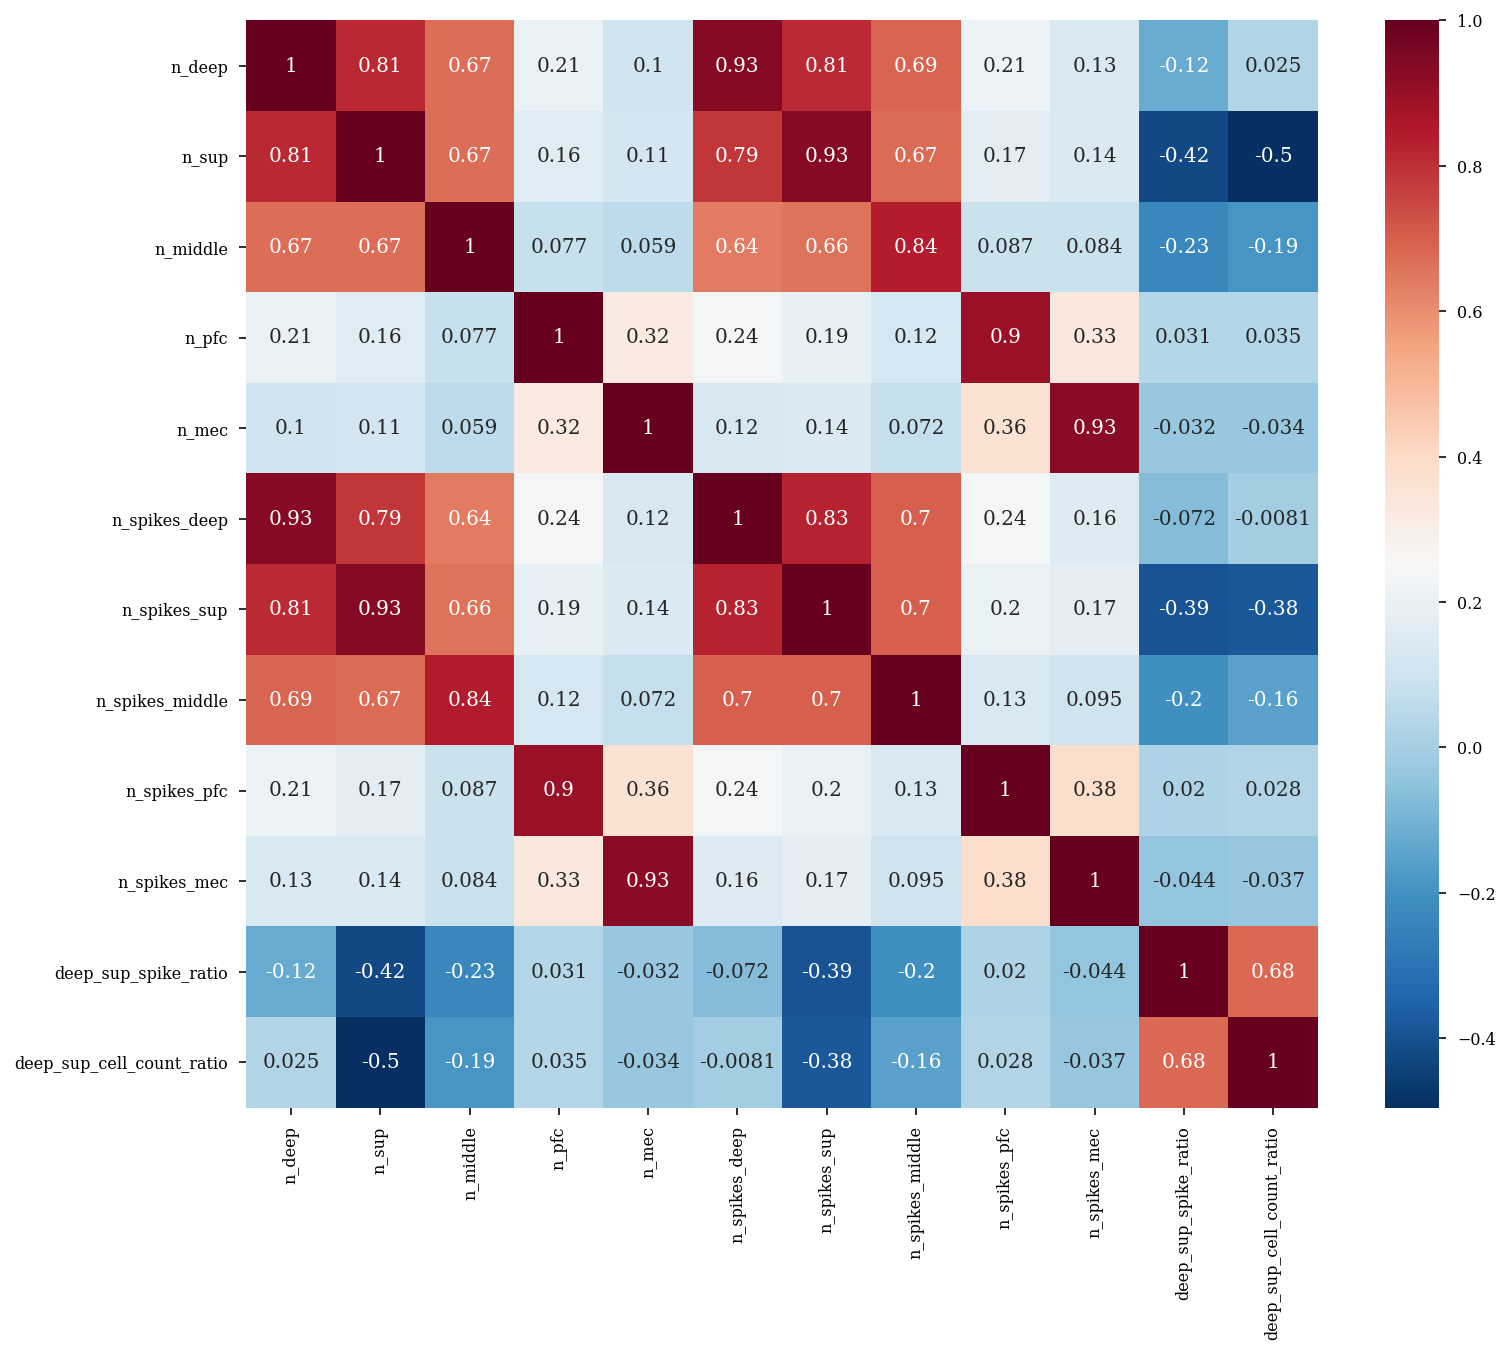

In [86]:
plt.figure(figsize=(12, 10))
sns.heatmap(results.corr(), annot=True, cmap="RdBu_r")


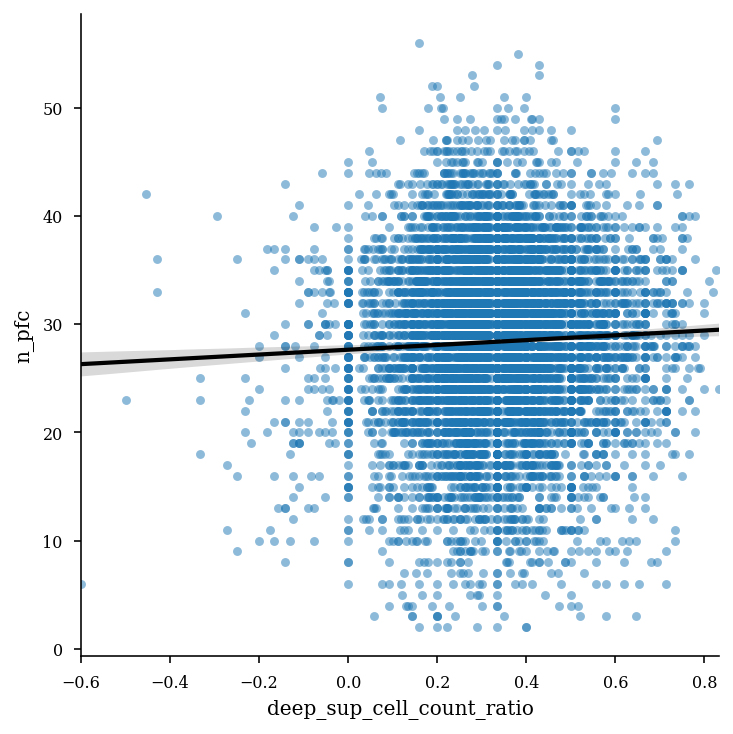

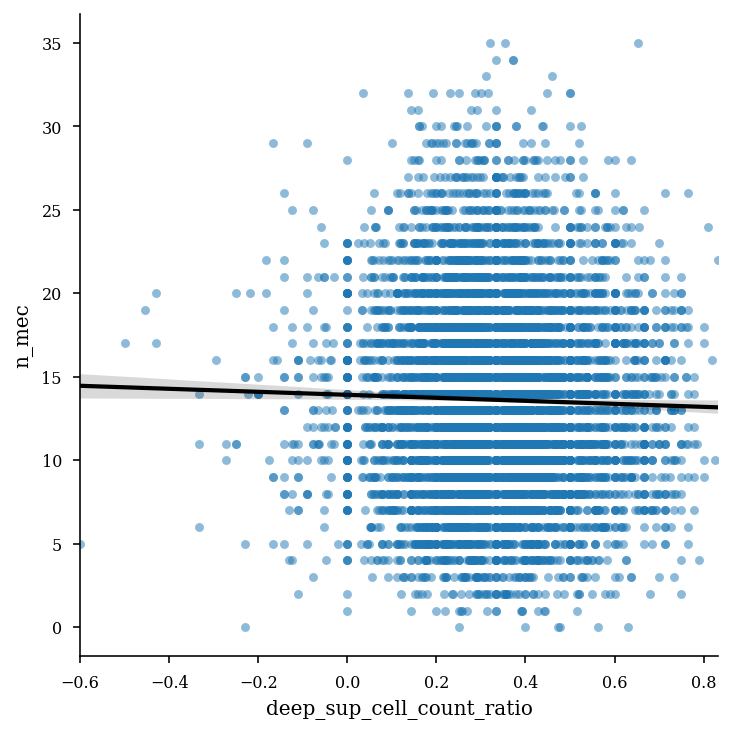

In [80]:
sns.lmplot(
    data=results.query("n_deep>1 & n_sup>1 & n_pfc>1"),
    x="deep_sup_cell_count_ratio",
    y="n_pfc",
    scatter_kws={"alpha": 0.5, "s": 20},
    line_kws={"color": "k"},
)
plt.show()
sns.lmplot(
    data=results.query("n_deep>1 & n_sup>1 & n_pfc>1"),
    x="deep_sup_cell_count_ratio",
    y="n_mec",
    scatter_kws={"alpha": 0.5, "s": 20},
    line_kws={"color": "k"},
)


<AxesSubplot:xlabel='n_deep', ylabel='n_spikes_pfc'>

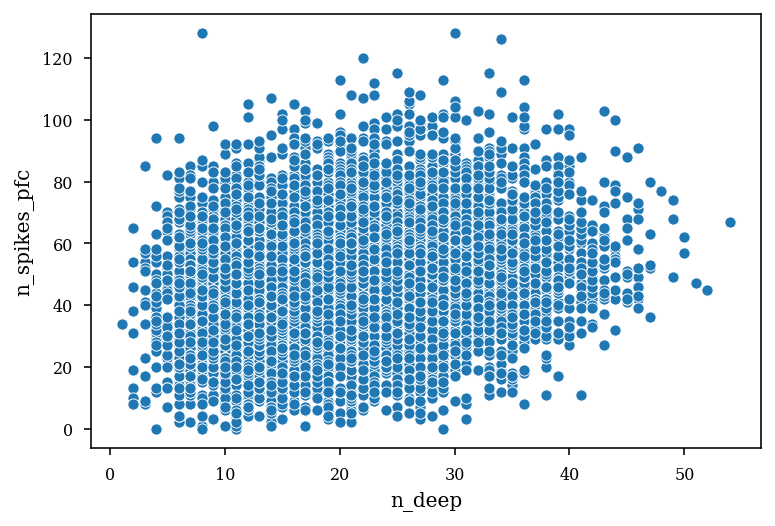

In [58]:
sns.scatterplot(data=results, x="n_deep", y="n_spikes_pfc")


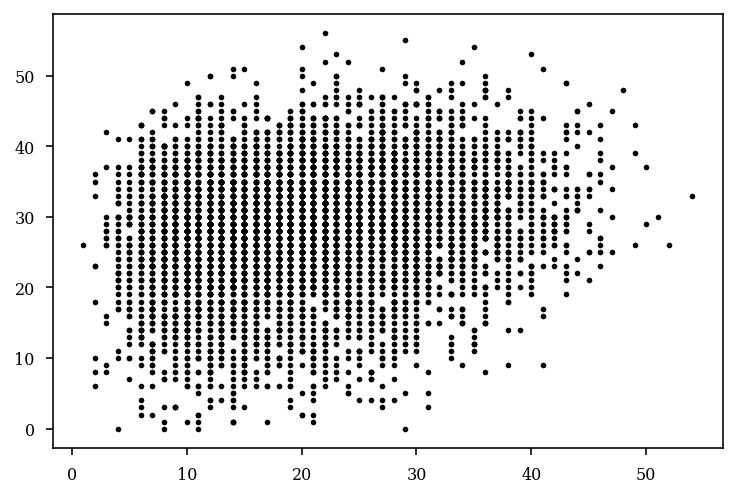

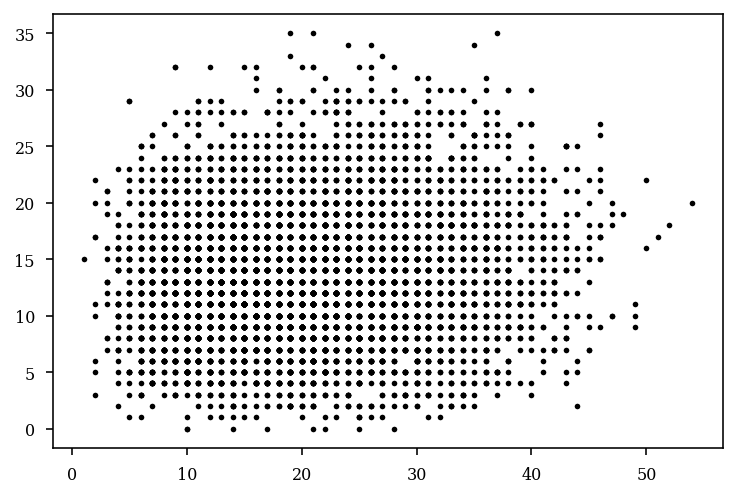

In [43]:
plt.plot(n_deep, n_pfc, ".k")
plt.show()
plt.plot(n_deep, n_mec, ".k")


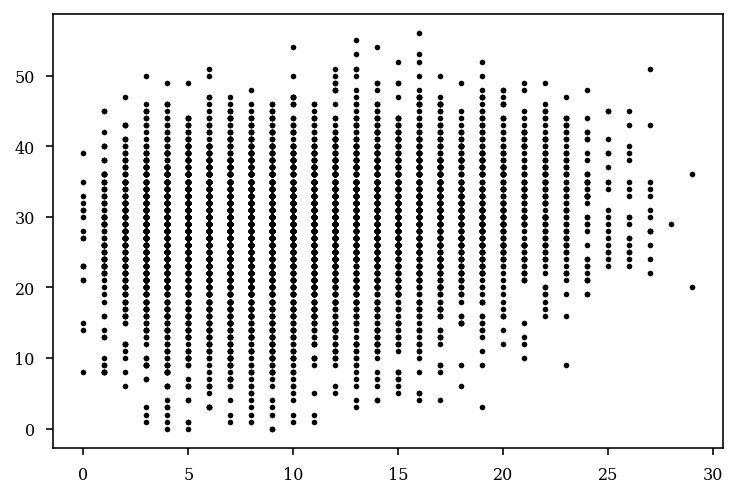

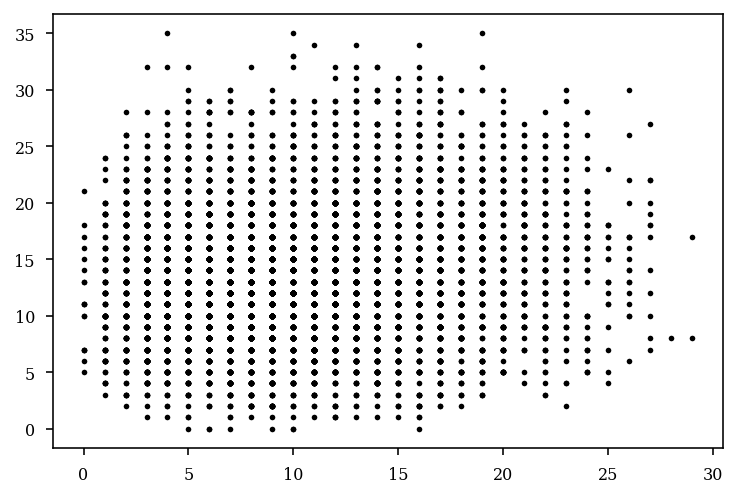

In [44]:
plt.plot(n_sup, n_pfc, ".k")
plt.show()
plt.plot(n_sup, n_mec, ".k")


In [31]:
cm.brainRegion[rip_par_mat[:, 0] > 0].value_counts().reset_index().rename(
    columns={"brainRegion": "count", "index": "brainRegion"}
)


,brainRegion,count
0,PFC,35
1,CA1,28
2,MEC,14
